In [45]:
import json
import os

kaggle_dict = {
    "username": "tiffanydegbotse",
    "key": "f867da44f8b08718e4c74e2eb26c56c9"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_dict, f)

!chmod 600 /root/.kaggle/kaggle.json


In [46]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [47]:
!pip install -q kaggle


In [48]:
!kaggle competitions list | head


ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3       2026-04-15 23:59:00  Featured         2,207,152 Usd       1902           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection            2026-02-13 23:59:00  Research           200,000 Usd       1290           False  
https://www.kaggle.com/competitions/stanford-rna-3d-folding-2                       2026-03-25 23:59:00  Featured           100,000 Usd        786           False  
https://www.kaggle.com/competitions/med-gemma-impact-challenge                      2026-02-24 23:59:00  Featured           100,000 Usd        113           False  
https://ww

In [49]:
!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge


galaxy-zoo-the-galaxy-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


## Dataset

In [50]:
import zipfile
import os

RAW_DIR = "/content/galaxy_zoo_raw"
DATA_DIR = "/content/galaxy_zoo"

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# Extract the main competition zip
with zipfile.ZipFile("/content/galaxy-zoo-the-galaxy-challenge.zip", "r") as z:
    z.extractall(RAW_DIR)

os.listdir(RAW_DIR)


['all_zeros_benchmark.zip',
 'central_pixel_benchmark.zip',
 'images_training_rev1.zip',
 'images_test_rev1.zip',
 'all_ones_benchmark.zip',
 'training_solutions_rev1.zip']

## Extracting images and labels

In [51]:
needed = [
    "images_training_rev1.zip",
    "training_solutions_rev1.zip"
]

for z in needed:
    with zipfile.ZipFile(os.path.join(RAW_DIR, z), "r") as zip_ref:
        zip_ref.extractall(DATA_DIR)

print(os.listdir(DATA_DIR))


['images_training_rev1', 'training_solutions_rev1.csv']


##Loading labels

In [52]:
import pandas as pd

labels = pd.read_csv("/content/galaxy_zoo/training_solutions_rev1.csv")
labels.head()


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


## Creating labels-focus on confidence (>0.7)

In [53]:
def assign_label(row):
    if row["Class1.1"] > 0.7:
        return "elliptical"
    elif row["Class1.2"] > 0.7:
        return "spiral"
    else:
        return None

labels["morphology"] = labels.apply(assign_label, axis=1)
labels = labels.dropna(subset=["morphology"])

labels["morphology"].value_counts()


,count
morphology,
spiral,22666
elliptical,14144


##Sampling a small balanced dataset

In [54]:
N_PER_CLASS = 2000

elliptical = labels[labels["morphology"] == "elliptical"].sample(
    n=N_PER_CLASS, random_state=42
)

spiral = labels[labels["morphology"] == "spiral"].sample(
    n=N_PER_CLASS, random_state=42
)

subset = pd.concat([elliptical, spiral]).reset_index(drop=True)

subset["morphology"].value_counts()


,count
morphology,
elliptical,2000
spiral,2000


## Attaching Image paths

In [55]:
IMG_DIR = "/content/galaxy_zoo/images_training_rev1"

subset["image_path"] = subset["GalaxyID"].apply(
    lambda x: os.path.join(IMG_DIR, f"{x}.jpg")
)

subset = subset[subset["image_path"].apply(os.path.exists)]
print("Final dataset size:", len(subset))


Final dataset size: 4000


## Train/validation/Test split

In [56]:
from sklearn.model_selection import train_test_split

# split out test set
trainval_df, test_df = train_test_split(
    subset,
    test_size=0.15,
    stratify=subset["morphology"],
    random_state=42
)

# split train vs validation
train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.2,
    stratify=trainval_df["morphology"],
    random_state=42
)

print("Train:", train_df["morphology"].value_counts())
print("Val:  ", val_df["morphology"].value_counts())
print("Test: ", test_df["morphology"].value_counts())


Train: morphology
spiral        1360
elliptical    1360
Name: count, dtype: int64
Val:   morphology
spiral        340
elliptical    340
Name: count, dtype: int64
Test:  morphology
elliptical    300
spiral        300
Name: count, dtype: int64


## Visualize some images

In [57]:
import matplotlib.pyplot as plt
from PIL import Image

def show_examples(df, label, n=5):
    examples = df[df["morphology"] == label].sample(n=n, random_state=42)

    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(examples.iterrows()):
        img = Image.open(row["image_path"])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")

    plt.show()


## Showing ellipticals

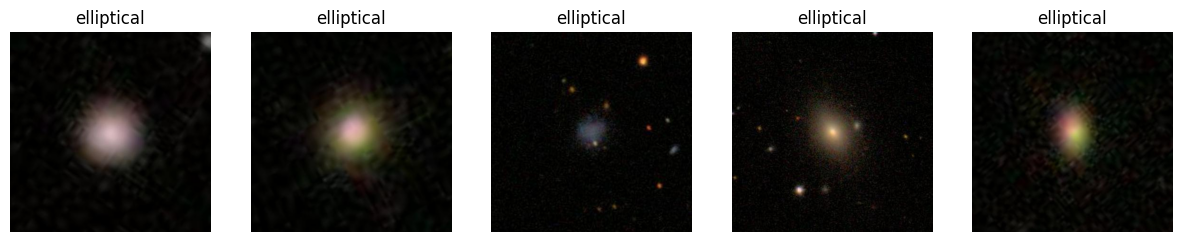

In [58]:
show_examples(subset, "elliptical", n=5)


## Showing spirals

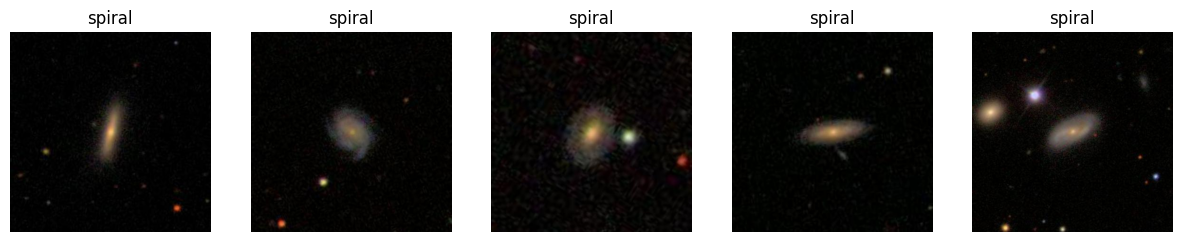

In [59]:
show_examples(subset, "spiral", n=5)


## Defining Label mapping

In [60]:
label_to_idx = {
    "elliptical": 0,
    "spiral": 1
}


## Naive Approach-Majority Class Baseline

In [61]:
majority_class = (
    train_df["morphology"]
    .map(label_to_idx)
    .mode()[0]
)

majority_class

np.int64(0)

In [62]:
y_true = test_df["morphology"].map(label_to_idx)
y_pred = [majority_class] * len(test_df)
print(y_pred)

[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)

## Calculating accuracy

In [63]:
from sklearn.metrics import accuracy_score

mod_accuracy = accuracy_score(y_true, y_pred)
mod_accuracy

0.5

## Classical ML

## Feature Extraction

In [64]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import moments_hu

def extract_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    features = []

    # Intensity stats
    features += [
        img.mean(),
        img.std()
    ]

    # Hu moments (shape)
    hu = moments_hu(img)
    features += hu.tolist()

    # GLCM texture
    glcm = graycomatrix(
        img,
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True
    )

    features += [
        graycoprops(glcm, 'contrast')[0,0],
        graycoprops(glcm, 'homogeneity')[0,0],
        graycoprops(glcm, 'energy')[0,0],
        graycoprops(glcm, 'correlation')[0,0]
    ]

    return np.array(features)


## Build feature matrix(Extract features per split)

In [65]:
# Extract features separately for each split
X_train = np.vstack(train_df["image_path"].apply(extract_features))
X_val   = np.vstack(val_df["image_path"].apply(extract_features))
X_test  = np.vstack(test_df["image_path"].apply(extract_features))

y_train = train_df["morphology"].map(label_to_idx).values
y_val   = val_df["morphology"].map(label_to_idx).values
y_test  = test_df["morphology"].map(label_to_idx).values


In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


## Hyperparameter fine tuning

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", 0.01, 0.001]
}

svm = SVC(kernel="rbf")

grid = GridSearchCV(
    svm,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Best parameters: {'C': 10, 'gamma': 'scale'}
Best CV accuracy: 0.6963235294117647


In [68]:
best_svm = grid.best_estimator_

## Evaluating tuned model

In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Validation (model selection / diagnostics)
y_val_pred = best_svm.predict(X_val_scaled)
print("Tuned SVM validation accuracy:", accuracy_score(y_val, y_val_pred))

# Test (reported result)
y_test_pred = best_svm.predict(X_test_scaled)
print("Tuned SVM test accuracy:", accuracy_score(y_test, y_test_pred))


Tuned SVM validation accuracy: 0.7
Tuned SVM test accuracy: 0.6883333333333334


## Confusion matrix on Test Set

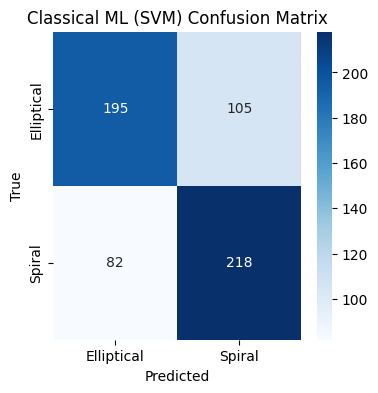

In [70]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(4,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Elliptical", "Spiral"],
    yticklabels=["Elliptical", "Spiral"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Classical ML (SVM) Confusion Matrix")
plt.show()


## Deep Learning Approach

## Defining the dataset class

In [71]:
from torch.utils.data import Dataset
from PIL import Image

class GalaxyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]

        # Load image
        img = Image.open(row["image_path"]).convert("RGB")

        # Convert label to integer
        label = label_to_idx[row["morphology"]]

        # Apply transforms
        if self.transform:
            img = self.transform(img)

        return img, label


## Baseline transform (no augmentation)

In [72]:
from torchvision import transforms

baseline_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


## Create dataset

In [73]:
train_dataset = GalaxyDataset(train_df, transform=baseline_transform)
val_dataset = GalaxyDataset(val_df, transform=baseline_transform)
test_dataset=GalaxyDataset(test_df, transform=baseline_transform)

len(train_dataset), len(val_dataset),len(test_dataset)


(2720, 680, 600)

## One sample check

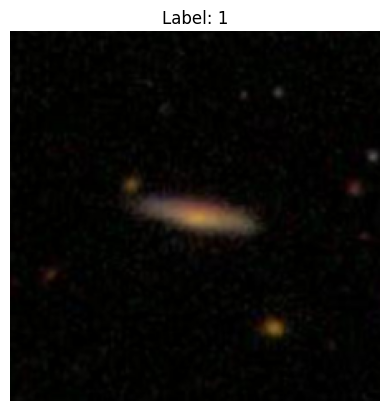

In [74]:
import matplotlib.pyplot as plt

img, label = train_dataset[0]

plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


## Augmentations added

In [75]:
robust_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    # Rotation: galaxies have no "up"
    transforms.RandomRotation(degrees=180),

    # Brightness & contrast: exposure + distance
    transforms.ColorJitter(
        brightness=0.4,
        contrast=0.4
    ),

    # Blur, atmospheric turbulence
    transforms.GaussianBlur(kernel_size=3),

    # Noise robustness (simulated via jitter + blur)
    transforms.ToTensor()
])


## Create robust dataset

In [76]:
train_dataset_robust = GalaxyDataset(
    train_df,
    transform=robust_transform
)

val_dataset_robust = GalaxyDataset(
    val_df,
    transform=baseline_transform
)
test_dataset_robust = GalaxyDataset(
    test_df,
    transform=baseline_transform
)


## Visual Sanity check

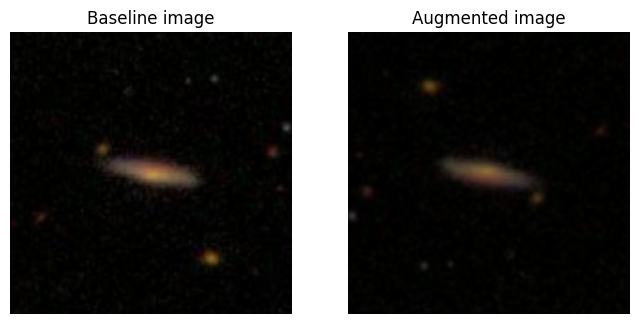

In [77]:
import matplotlib.pyplot as plt

img_clean, _ = GalaxyDataset(train_df, baseline_transform)[0]
img_aug, _ = GalaxyDataset(train_df, robust_transform)[0]

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img_clean.permute(1,2,0))
plt.title("Baseline image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_aug.permute(1,2,0))
plt.title("Augmented image")
plt.axis("off")

plt.show()


## Creating data loaders

In [78]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

train_loader_robust = DataLoader(
    train_dataset_robust,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)



## Defining the model for transfer learning

In [79]:
def get_model(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last residual block
    for param in model.layer4.parameters():
        param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


Training loop

In [82]:
import torch.optim as optim

def train_model(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # TRAIN
        model.train()
        running_train_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # VALIDATION
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        acc = correct / total

        print(
            f"Epoch {epoch+1} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Val Acc: {acc:.3f}"
        )

    return train_losses, val_losses


## Experimenting with learning rates

In [83]:
learning_rates = [1e-3, 1e-4, 3e-5]
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate {lr}")
    model = get_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = train_model(
        model,
        train_loader_robust,
        val_loader,
        epochs=5
    )

    results[lr] = val_losses[-1]



Training with learning rate 0.001
Epoch 1 | Train Loss: 0.3752 | Val Loss: 0.2907 | Val Acc: 0.881
Epoch 2 | Train Loss: 0.2582 | Val Loss: 0.2351 | Val Acc: 0.907
Epoch 3 | Train Loss: 0.2476 | Val Loss: 0.2166 | Val Acc: 0.915
Epoch 4 | Train Loss: 0.2225 | Val Loss: 0.2030 | Val Acc: 0.929
Epoch 5 | Train Loss: 0.2155 | Val Loss: 0.2418 | Val Acc: 0.909

Training with learning rate 0.0001
Epoch 1 | Train Loss: 0.3632 | Val Loss: 0.2926 | Val Acc: 0.879
Epoch 2 | Train Loss: 0.2584 | Val Loss: 0.2331 | Val Acc: 0.906
Epoch 3 | Train Loss: 0.2332 | Val Loss: 0.2337 | Val Acc: 0.906
Epoch 4 | Train Loss: 0.2267 | Val Loss: 0.2391 | Val Acc: 0.913
Epoch 5 | Train Loss: 0.2147 | Val Loss: 0.2243 | Val Acc: 0.910

Training with learning rate 3e-05
Epoch 1 | Train Loss: 0.3506 | Val Loss: 0.2803 | Val Acc: 0.881
Epoch 2 | Train Loss: 0.2514 | Val Loss: 0.2229 | Val Acc: 0.903
Epoch 3 | Train Loss: 0.2396 | Val Loss: 0.2306 | Val Acc: 0.913
Epoch 4 | Train Loss: 0.2211 | Val Loss: 0.2257 |

## Training baseline model

In [84]:
print("Training BASELINE model")
baseline_model = get_model(num_classes=3)
baseline_train_loss, baseline_val_loss = train_model(
    baseline_model,
    train_loader,
    val_loader
)

Training BASELINE model
Epoch 1 | Train Loss: 0.4761 | Val Loss: 0.2811 | Val Acc: 0.899
Epoch 2 | Train Loss: 0.1230 | Val Loss: 0.2657 | Val Acc: 0.918
Epoch 3 | Train Loss: 0.0470 | Val Loss: 0.3060 | Val Acc: 0.907
Epoch 4 | Train Loss: 0.0176 | Val Loss: 0.3128 | Val Acc: 0.912
Epoch 5 | Train Loss: 0.0144 | Val Loss: 0.3331 | Val Acc: 0.906
Epoch 6 | Train Loss: 0.0088 | Val Loss: 0.3404 | Val Acc: 0.915
Epoch 7 | Train Loss: 0.0051 | Val Loss: 0.3450 | Val Acc: 0.913
Epoch 8 | Train Loss: 0.0044 | Val Loss: 0.3578 | Val Acc: 0.922
Epoch 9 | Train Loss: 0.0046 | Val Loss: 0.3989 | Val Acc: 0.916
Epoch 10 | Train Loss: 0.0055 | Val Loss: 0.4526 | Val Acc: 0.894


## Visualizing training vs validation loss

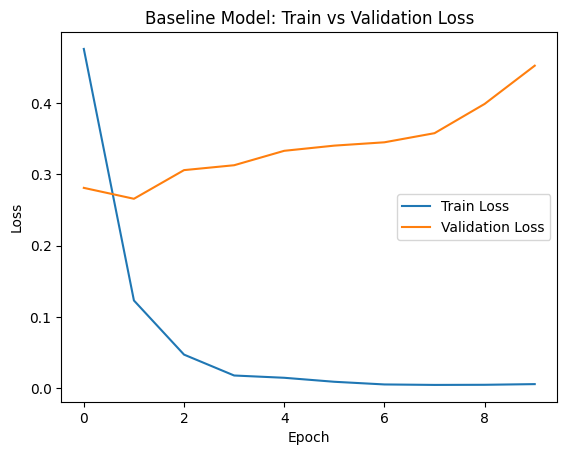

In [85]:
import matplotlib.pyplot as plt

plt.plot(baseline_train_loss, label="Train Loss")
plt.plot(baseline_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline Model: Train vs Validation Loss")
plt.legend()
plt.show()


## Training roboust model

In [86]:
robust_model = get_model()
robust_train_loss, robust_val_loss = train_model(
    robust_model,
    train_loader_robust,
    val_loader
)


Epoch 1 | Train Loss: 0.3542 | Val Loss: 0.2860 | Val Acc: 0.890
Epoch 2 | Train Loss: 0.2644 | Val Loss: 0.2217 | Val Acc: 0.904
Epoch 3 | Train Loss: 0.2380 | Val Loss: 0.2334 | Val Acc: 0.903
Epoch 4 | Train Loss: 0.2291 | Val Loss: 0.2295 | Val Acc: 0.913
Epoch 5 | Train Loss: 0.2071 | Val Loss: 0.1839 | Val Acc: 0.926
Epoch 6 | Train Loss: 0.2035 | Val Loss: 0.2136 | Val Acc: 0.912
Epoch 7 | Train Loss: 0.2168 | Val Loss: 0.2124 | Val Acc: 0.918
Epoch 8 | Train Loss: 0.1900 | Val Loss: 0.2056 | Val Acc: 0.921
Epoch 9 | Train Loss: 0.1846 | Val Loss: 0.1941 | Val Acc: 0.926
Epoch 10 | Train Loss: 0.1847 | Val Loss: 0.1943 | Val Acc: 0.922


## Visualizing training vs validation loss

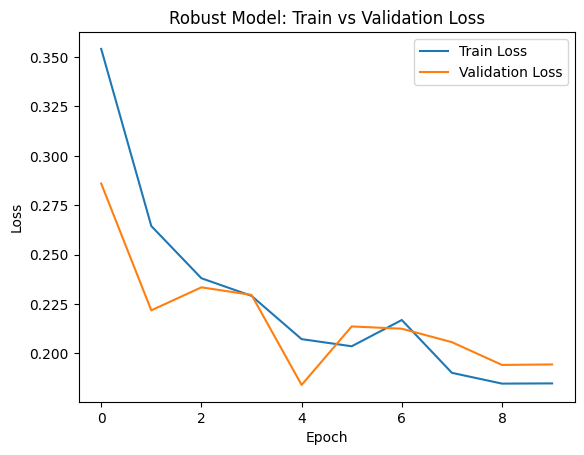

In [87]:
import matplotlib.pyplot as plt

plt.plot(robust_train_loss, label="Train Loss")
plt.plot(robust_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Robust Model: Train vs Validation Loss")
plt.legend()
plt.show()


## Evaluation function

In [88]:
import torch
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)


## Confusion matrices

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Baseline
y_true_base, y_pred_base = evaluate_model(baseline_model, test_loader)

# Robust
y_true_robust, y_pred_robust = evaluate_model(robust_model, test_loader)


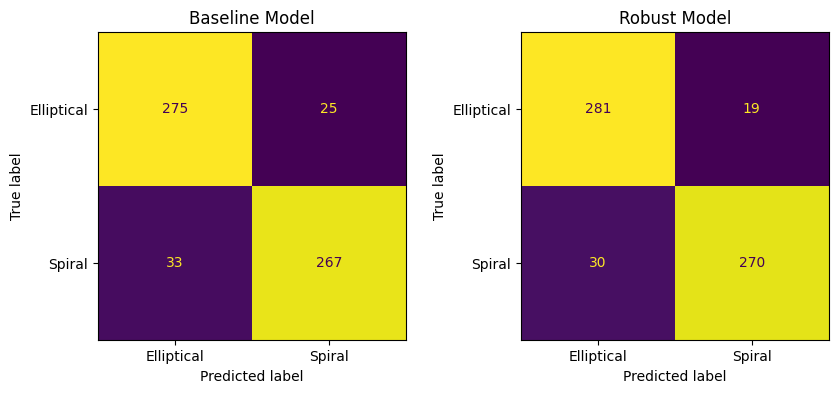

In [90]:
labels = ["Elliptical", "Spiral"]

fig, axes = plt.subplots(1, 2, figsize=(10,4))

ConfusionMatrixDisplay(
    confusion_matrix(y_true_base, y_pred_base),
    display_labels=labels
).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Baseline Model")

ConfusionMatrixDisplay(
    confusion_matrix(y_true_robust, y_pred_robust),
    display_labels=labels
).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Robust Model")

plt.show()


## Visualize predictions

In [91]:
idx_to_label = {0: "Elliptical", 1: "Spiral"}

def show_predictions(model, dataset, n=6):
    model.eval()
    plt.figure(figsize=(12, 6))

    for i in range(n):
        img, label = dataset[i]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device)).argmax(dim=1).item()

        plt.subplot(2, n//2, i+1)
        plt.imshow(img.permute(1,2,0))
        plt.title(f"GT: {idx_to_label[label]}\nPred: {idx_to_label[pred]}")
        plt.axis("off")

    plt.show()


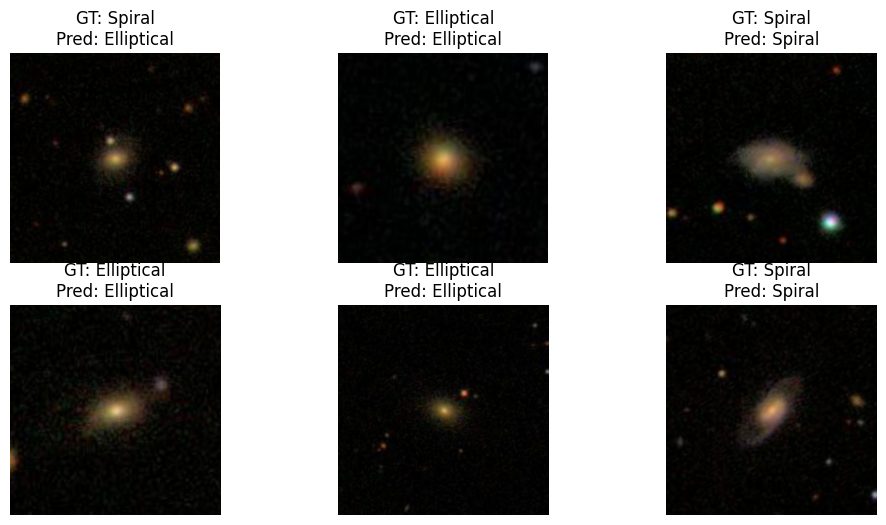

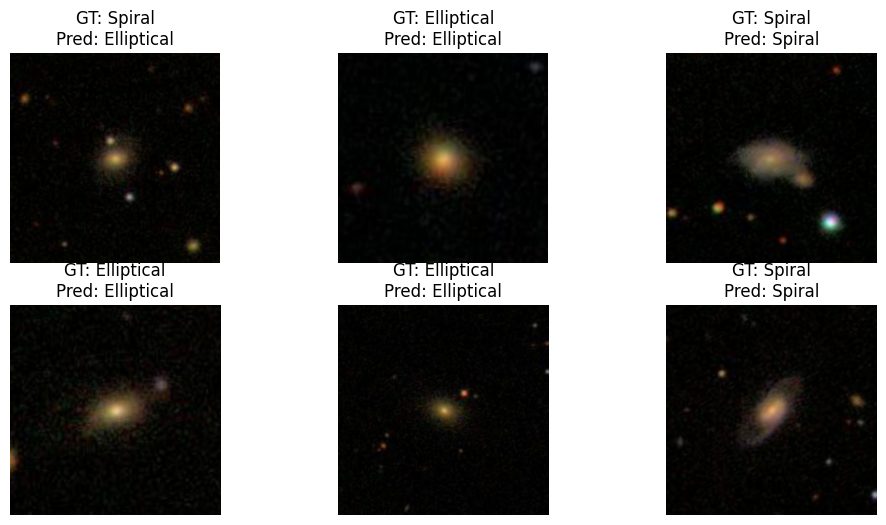

In [92]:
show_predictions(baseline_model, val_dataset)
show_predictions(robust_model, val_dataset)


## Evaluate Accuracy

In [93]:
import numpy as np
import torch

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)


## Baseline model

In [94]:
y_true_base, y_pred_base = evaluate_model(baseline_model, test_loader)


## Robust model

In [95]:
y_true_robust, y_pred_robust = evaluate_model(robust_model, test_loader)


## Test Accuracy

In [96]:
from sklearn.metrics import accuracy_score

baseline_test_acc = accuracy_score(y_true_base, y_pred_base)
robust_test_acc = accuracy_score(y_true_robust, y_pred_robust)

print(f"Baseline test accuracy: {baseline_test_acc:.3f}")
print(f"Robust test accuracy:   {robust_test_acc:.3f}")


Baseline test accuracy: 0.903
Robust test accuracy:   0.918


## To Save models

In [97]:
#torch.save(baseline_model.state_dict(), "baseline_galaxy_model.pth")
#torch.save(robust_model.state_dict(), "robust_galaxy_model.pth")


## To reload models

In [98]:
#model = get_model()
#model.load_state_dict(torch.load("robust_galaxy_model.pth"))
